<a href="https://colab.research.google.com/github/SethCram/CS474-Deep-Learning/blob/main/HW4/HW4_CNN_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras 
from keras import layers
from keras import optimizers
from keras import applications
from keras import losses
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import os

In [ ]:
## Google Colab Cell

#enable debugging
!pip install -Uqq ipdb
import ipdb
%pdb on

#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/School/Senior Year/CS 474-01 (Deep Learning)/

In [2]:
#Load data
df=pd.read_csv('https://raw.githubusercontent.com/SethCram/CS474-Deep-Learning/main/HW4/train.csv', sep = ',')
print(df)

training_imgs_path = 'trainImgs/'
test_imgs_path = 'testImgs/'

# store training and test imgs greyscaled 
x_train_diff_reses = np.array([
        cv.imread(training_imgs_path + row[1] + ".png", 0).astype('float32') for row in df.values], 
        dtype='object'
    )
x_test_diff_reses = np.array([
        cv.imread(test_imgs_path + str(i) + ".png", 0).astype('float32') 
        for i in range(1248)], 
        dtype='object'
    )

      Unnamed: 0         img name  tumor types
0              0           000137            1
1              1         case0419            1
2              2         case0024            0
3              3     benign (397)            0
4              4         case0287            0
...          ...              ...          ...
2379        2379  malignant (143)            1
2380        2380         case0441            1
2381        2381     benign (162)            0
2382        2382           000064            0
2383        2383           000022            0

[2384 rows x 3 columns]


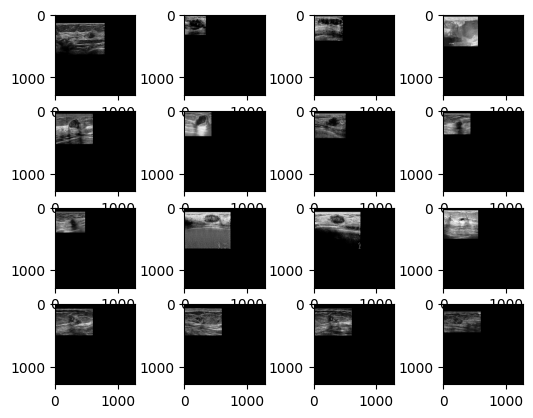

Data shape: x_train: (2384, 1283, 1283) x_test: (1248, 1283, 1283)
Data shape: y_train: (2384,) y_test: (1248,)


In [3]:
#ONLY RUNNABLE A SINGLE TIME PER SESSION
def load_imgs(x_train_size, x_test_size, max_width, max_height, show_sample = True, batch_size=100):
    
    ## Data Preprocessing
    
    #need to do some sort of zero/same padding to get same image sizes
    # unless using fully convolutional NN bc can take inputs of different sizes
    # or if use a spatial pyramid pooling (SPP) layer before dense layers
    
    #Could possibly create more training data thru upscaling/downscaling
    # would better recognise diff scaled data
    
    x_train = np.empty((x_train_size, max_width, max_height), dtype='float32')
    x_test = np.empty((x_test_size, max_width, max_height), dtype='float32')
    
    for i, image in enumerate(x_train_diff_reses):
        #x_train_diff_reses[i] = pad_image(
        #    image, 
        #    biggest_training_width, 
        #    biggest_training_height
        #)
        
        x_train[i] = cv.copyMakeBorder(
            image, 
            0, 
            max_height-image.shape[0], 
            0, 
            max_width-image.shape[1], 
            cv.BORDER_CONSTANT
        )

    #x_train = np.expand_dims(x_train, -1)

    for i, image in enumerate(x_test_diff_reses):
        #x_train_diff_reses[i] = pad_image(
        #    image, 
        #    biggest_training_width, 
        #    biggest_training_height
        #)
        
        x_test[i] = cv.copyMakeBorder(
            image, 
            0, 
            max_height-image.shape[0], 
            0, 
            max_width-image.shape[1], 
            cv.BORDER_CONSTANT
        )

    #x_test = np.expand_dims(x_test, -1)
    
    #assert biggest_test_width == min( image.shape[0] for image in x_test_diff_reses )
    #assert biggest_test_height == min( image.shape[1] for image in x_test_diff_reses )
    
    #assert biggest_training_width == min( image.shape[0] for image in x_train_diff_reses )
    #assert biggest_training_height == min( image.shape[1] for image in x_train_diff_reses )

    #m = len(x_train_diff_reses)
    #for b in range(int(m/batch_size)):
    #    b_start= b*batch_size
    #    b_end = min((b+1)*batch_size, m)
    #    
    #    x_batch = x_train_diff_reses[b_start:b_end]
    #    x_train[b_start:b_end] = construct_image_batch(x_batch)
    
    #store whether benign (0?) or malignant (1?)
    y_train = np.array([row[2] for row in df.values], dtype='float32')
    y_test = np.zeros(x_test.shape[0], dtype='float32') #no labels on test data??
    
    #show first 100 images
    if show_sample == True:
        nImg = 4
        for i in range(nImg*nImg):
            plt.subplot(nImg, nImg, i+1)
            plt.imshow(x_train[i], cmap = 'Greys_r')
        plt.show()
        
    #x_train = np.reshape(x_train, [x_train.shape[0], x_train.shape[1] * x_train.shape[2]]) #adds 2nd dim of 1
    #x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1] * x_test.shape[2]]) #adds 2nd dim of 1
        
    return x_train, y_train, x_test, y_test

#Get training and test max resolutions
biggest_training_width = max( image.shape[0] for image in x_train_diff_reses )
biggest_training_height = max( image.shape[1] for image in x_train_diff_reses )

biggest_test_width = max( image.shape[0] for image in x_test_diff_reses )
biggest_test_height = max( image.shape[1] for image in x_test_diff_reses )

#get max width and height of any input image
max_width = max( [biggest_test_width, biggest_training_width] )
max_height = max( [biggest_test_height, biggest_training_height] )

x_train, y_train, x_test, y_test = load_imgs(len(x_train_diff_reses), len(x_test_diff_reses), max_width, max_height,)

print('Data shape:', 'x_train:', x_train.shape, 'x_test:', x_test.shape)
print('Data shape:', 'y_train:', y_train.shape, 'y_test:', y_test.shape)


In [ ]:
#preprocess_input = keras.applications.mobilenet_v2.preprocess_input

## load the cancer dataset
def construct_image_batch(image_group):
    
    # get the max image shape
    max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(2))

    # construct an image batch object
    image_batch = np.zeros((len(image_group),) + max_shape, dtype='float32')

    # copy all images to the upper left part of the image batch object
    for image_index, image in enumerate(image_group):
        image_batch[image_index, :image.shape[0], :image.shape[1]] = image

    return image_batch

def pad_image(image, maxX, maxY):
    #apply zero padding to smaller images
    zero_image = np.zeros(
        (maxX, maxY),
         dtype='float32'
    )
    # copy image to the upper left part of zero image
    zero_image[:image.shape[0], :image.shape[1]] = image
    
    return zero_image

In [ ]:
# expand dims for channels?

#model = applications.resnet_v2.ResNet101V2(
#    include_top=False,
#    weights='imagenet',
#    input_tensor=x_train,
#    input_shape=x_train.shape,
#    pooling=None,
#    classes=1,
#    classifier_activation='softmax'
#)

desiredLevels = 2

def CreateConvLayer(convLayers, model, filters, kernel_size, activation = None, padding = "valid"):
    conv = layers.Conv2D(
        filters= filters, #num of filters for conv
        kernel_size = kernel_size, 
        padding = padding,
        activation = activation,
        #input_shape = (28, 28, 1) #only 28 params 
    )
    
    convLayers.append(conv)
    model.add(conv)
    
def CreateMaxPoolLayer(poolLayers, model, pool_size, strides):
    pool = layers.MaxPooling2D(
        pool_size = pool_size,
        strides = strides,
    )
    
    poolLayers.append(pool)
    model.add(pool)
    
def CreateConvBlock(
    model, convLayers, poolLayers, normLayers, activationLayers,
    filters, kernel_size, activation,
    pool_size, strides
):
    CreateConvLayer(convLayers, model, filters, kernel_size)
    #CreateMaxPoolLayer(poolLayers, model, pool_size, strides)
    
    dropout = layers.Dropout(0.2)
    model.add(dropout)
    
    norm = layers.BatchNormalization()
    model.add(norm)
    normLayers.append(norm)

    activ = layers.Activation(activation)
    model.add(activ)
    activationLayers.append(activ)
    
# Create a fully conv NN
model_fcn = keras.Sequential()

convLayers = []
poolLayers = []
normLayers = []
activationLayers = []

# Input layer
input = layers.Input(shape=(None, None, 1))
model_fcn.add(input)

CreateConvBlock(
    model_fcn, convLayers, poolLayers, normLayers, activationLayers,
    filters=8, kernel_size=3, activation='relu',
    pool_size=2, strides=2
)

CreateConvBlock(
    model_fcn, convLayers, poolLayers, normLayers, activationLayers,
    filters=16, kernel_size=3, activation='softmax',
    pool_size=2, strides=2
)

globMaxPool = layers.GlobalMaxPooling2D()
model_fcn.add(globMaxPool)

#model_fcn(inputs=x_train, outputs=y_train)

#need normalization and output layers

#specify optimization
model_fcn.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model_fcn.summary()



In [4]:
#CNN model
model_CNN = keras.Sequential()

conv_1_layer = layers.Conv2D(
        input_shape=(max_width, max_height, 1),
        filters=64,
        kernel_size=3,
        activation='relu'
    )
model_CNN.add(conv_1_layer)

conv_2_layer = layers.Conv2D(
        filters=32,
        kernel_size=3,
        activation='relu'
    )
model_CNN.add(conv_2_layer)

conv_3_layer = layers.Conv2D(
        filters=16,
        kernel_size=3,
        activation='relu'
    )
model_CNN.add(conv_3_layer)

flatten_layer = layers.Flatten()
model_CNN.add(flatten_layer)

output_layer = layers.Dense(1, activation='softmax')
model_CNN.add(output_layer)

model_CNN.compile(
    optimizer='adam', #to deal with noise
    loss=losses.BinaryCrossentropy(), #or just categorical_crossentropy?
    metrics=['accuracy']
)

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1281, 1281, 64)    640       
                                                                 
 conv2d_1 (Conv2D)           (None, 1279, 1279, 32)    18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 1277, 1277, 16)    4624      
                                                                 
 flatten (Flatten)           (None, 26091664)          0         
                                                                 
 dense (Dense)               (None, 1)                 26091665  
                                                                 
Total params: 26,115,393
Trainable params: 26,115,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train model
history_CNN = model_CNN.fit(
    x_train,
    y_train,
    epochs=5, 
    batch_size=2, #1 epoch ETA = 2:15:00, 2 epoch ETA = 1:53:00 works; 10, 64 doesn't work bc OOM 
    validation_split=0.2 
)

In [ ]:
def construct_image_batch(image_group, BATCH_SIZE):
    # get the max image shape
    max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))

    # construct an image batch object
    image_batch = np.zeros((BATCH_SIZE,) + max_shape, dtype='float32')

    # copy all images to the upper left part of the image batch object
    for image_index, image in enumerate(image_group):
        image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

    return image_batch

classes = 2

# Input layer
input = layers.Input(shape=(231, 231, 1)) #test with smallest input shape to determine # of conv blocks?

# input convolution block
x = layers.Conv2D(filters=128, kernel_size=3, strides=1)(input)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# middle convolution block
#x = layers.Conv2D(filters=64, kernel_size=3, strides=1)(x)
#x = layers.Dropout(0.2)(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)

# middle convolution block
#x = layers.Conv2D(filters=32, kernel_size=3, strides=1)(x)
#x = layers.Dropout(0.2)(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)

# final convolution block
x = layers.Conv2D(filters=classes, kernel_size=1, strides=1)(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalMaxPooling2D()(x)
predictions = layers.Activation('relu')(x)

model = keras.Model(inputs=input, outputs=predictions)
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 231, 231, 1)]     0         
                                                                 
 conv2d_50 (Conv2D)          (None, 229, 229, 128)     1280      
                                                                 
 dropout_49 (Dropout)        (None, 229, 229, 128)     0         
                                                                 
 batch_normalization_49 (Bat  (None, 229, 229, 128)    512       
 chNormalization)                                                
                                                                 
 activation_42 (Activation)  (None, 229, 229, 128)     0         
                                                                 
 conv2d_51 (Conv2D)          (None, 229, 229, 2)       258       
                                                          

In [ ]:
def train(model, train_generator, val_generator, epochs = 50):
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    checkpoint_path = './snapshots'
    os.makedirs(checkpoint_path, exist_ok=True)
    model_path = os.path.join(checkpoint_path, 'model_epoch_{epoch:02d}_loss_{loss:.2f}_acc_{acc:.2f}_val_loss_{val_loss:.2f}_val_acc_{val_acc:.2f}.h5')
    
    history = model.fit_generator(generator=train_generator,
            steps_per_epoch=len(train_generator),
            epochs=epochs,
            callbacks=[keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)],
            validation_data=val_generator,
            validation_steps=len(val_generator)
        )

    return history

#train model
history = model_fcn.fit(
    x_train, #should be 2d inputs
    y_train, #already onehot
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_split=0.2,
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [ ]:
#test accuracy
y_test_pred = model_fcn.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1) #still need to do bc pred is prob?
test_err = np.sum(y_test == y_test_pred) / y_test.shape[0]

print(f'test accuracy: {test_err * 100}')

In [ ]:
#history of training and validation accuracu
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training acc', 'validation acc'])

In [ ]:
#get access to filters/kernels
weights = convLayers[0].get_weights()[0][:, :, 0, :] #arr of a buncha nested lists, 0 bc only have 1 channel (28, 28, 1, 8)

#can get access to other params this way 

for i in range(1, 8):
    plt.subplot(2, 4, i)
    plt.imshow(weights[:,:,i], cmap="gray")
plt.show()

#how get access to feature maps?